In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dst, idst

In [2]:
class advection_diffusion:
    def __init__(self,dt,dx,c=1.0,sigma=1e-3):
        self.c=c
        self.sigma=sigma
        self.dt = dt
        self.dx = dx
        self.nu = self.c * self.dt / self.dx
        self.mu = self.sigma*self.dt / self.dx / self.dx
        print(f"nu={self.nu} mu={self.mu}")
    
    def __call__(self,u):
        return (self.nu+self.mu)*np.roll(u,1,axis=0) + (1.-self.nu-2.*self.mu)*u + self.mu*np.roll(u,-1,axis=0)
    
    def step_t(self,u):
        return self.__call__(u)

In [3]:
# Domain and step size definition
L = 1.0
T = 0.5
dx = 0.0625
dt = 0.05
dx_t = dx / 8.
dt_t = dt / 64.
dx_gm = dx
dt_gm = dt
dx_lam = dx / 4.
dt_lam = dt / 16.
lamstep = int(dt_gm / dt_lam)
obsstep = int(dt_lam / dt_t)
nx_t = int(L / dx_t)
ix_t = np.arange(1,nx_t+1)
x_t = np.linspace(dx_t,L,nx_t)
nx_gm = int(L / dx_gm)
ix_gm = np.arange(1,nx_gm+1)*int(nx_t/nx_gm)
x_gm = np.linspace(dx_gm,L,nx_gm)
Ls_lam = 0.5
nx_lam = int((L - Ls_lam) / dx_lam) + 1
x_lam = np.linspace(Ls_lam,L,nx_lam)
ix_lam = x_lam * nx_t / L
nsponge = 3
print(f"nx_t={nx_t} nx_gm={nx_gm} nx_lam={nx_lam}")
print(f"dx_t={dx_t} dx_gm={dx_gm} dx_lam={dx_lam}")
print(f"dt_t={dt_t} dt_gm={dt_gm} dt_lam={dt_lam}")

nx_t=128 nx_gm=16 nx_lam=33
dx_t=0.0078125 dx_gm=0.0625 dx_lam=0.015625
dt_t=0.00078125 dt_gm=0.05 dt_lam=0.003125


In [4]:
from analysis.obs import Obs
sigo = 0.5
obsope = Obs('linear',sigo)

2024-01-31 20:58:34,838 anl INFO operator=linear, obserr=0.5
2024-01-31 20:58:34,838 anl INFO nvars=1


nu=0.1 mu=0.0128


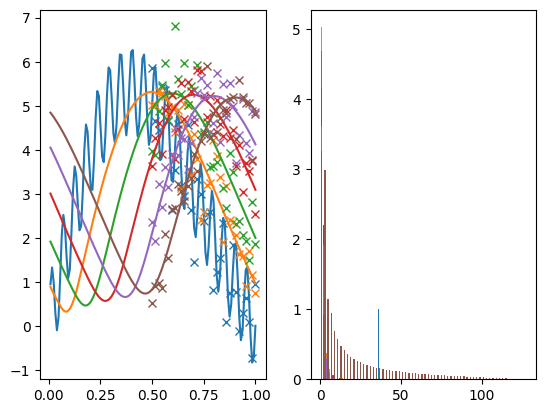

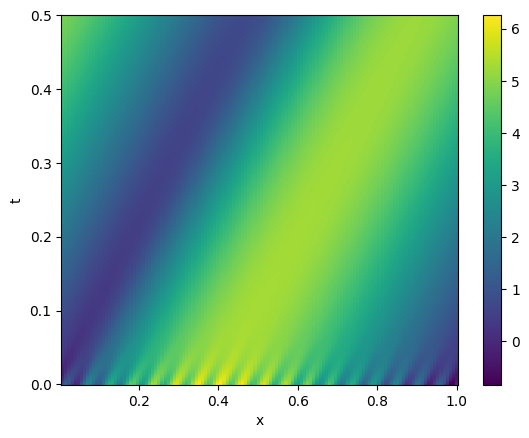

In [6]:
nature = advection_diffusion(dt_t,dx_t)
u0_t = 5.*np.sin(np.pi*x_t) + np.sin(2.0*np.pi*x_t) + np.sin(36.*np.pi*x_t)
u_t = []
obs = []
time = []
time_obs = []
t = 0.0
u_t.append(u0_t)
time.append(t)
yobs = obsope.add_noise(obsope.h_operator(ix_lam, u0_t))
obs.append(yobs)
time_obs.append(t)
i = 0
cmap = plt.get_cmap('tab10')
fig, axs = plt.subplots(ncols=2)
axs[0].plot(x_t,u0_t)
y_t = dst(u0_t[:-1],type=1)/nx_t
axs[1].bar(np.arange(1,y_t.size+1),np.abs(y_t))
axs[0].plot(x_lam,yobs,lw=0.0,marker='x',c=cmap(i//128))
while (t<T):
    u0_t = nature(u0_t)
    t+=dt_t
    i+=1
    u_t.append(u0_t)
    time.append(t)
    if i%128==0:
        axs[0].plot(x_t,u0_t,c=cmap(i//128))
        y_t = dst(u0_t[:-1],type=1)/nx_t
        axs[1].bar(np.arange(1,y_t.size+1),np.abs(y_t),color=cmap(i//128))
    if i%obsstep==0:
        yobs = obsope.add_noise(obsope.h_operator(ix_lam, u0_t))
        obs.append(yobs)
        time_obs.append(t)
        if i%128==0: axs[0].plot(x_lam,yobs,lw=0.0,marker='x',c=cmap(i//128))
plt.show()

p=plt.pcolormesh(x_t,time,np.array(u_t))
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(p)
plt.show()

nu=0.8 mu=0.0128
nu=0.2 mu=0.0128


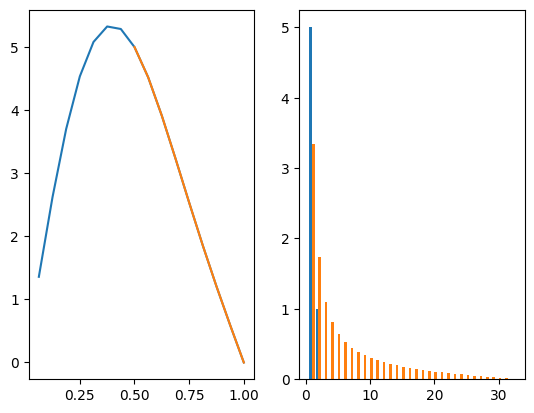

In [7]:
from scipy.interpolate import interp1d
gm = advection_diffusion(dt_gm,dx_gm)
lam = advection_diffusion(dt_lam,dx_lam)

u0_gm = 5.*np.sin(np.pi*x_gm) + np.sin(2.0*np.pi*x_gm)
gm2lam = interp1d(x_gm,u0_gm)
u0_lam = gm2lam(x_lam)

fig, axs = plt.subplots(ncols=2)
axs[0].plot(x_gm,u0_gm)
axs[0].plot(x_lam,u0_lam)
y_gm = dst(u0_gm[:-1],type=1)/nx_gm
axs[1].bar(np.arange(1,y_gm.size+1)-0.2,np.abs(y_gm),width=0.4)
y_lam = dst(u0_lam[:-1],type=1)/nx_lam
axs[1].bar(np.arange(1,y_lam.size+1)+0.2,np.abs(y_lam),width=0.4)
plt.show()

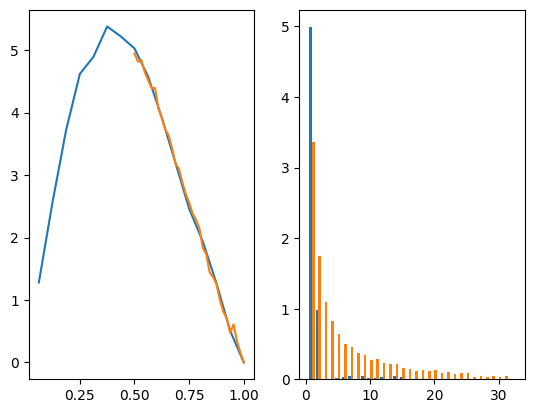

In [8]:
from numpy.random import default_rng
rng = default_rng()
sigb = 0.5
yp_gm = y_gm*nx_gm + rng.normal(0, scale=sigb, size=y_gm.size)
up_gm = np.zeros_like(u0_gm)
up_gm[:-1] = idst(yp_gm,type=1)
yp_lam = y_lam*nx_lam + rng.normal(0, scale=sigb, size=y_lam.size)
up_lam = np.zeros_like(u0_lam)
up_lam[:-1] = idst(yp_lam,type=1)

fig, axs = plt.subplots(ncols=2)
axs[0].plot(x_gm,up_gm)
axs[0].plot(x_lam,up_lam)
axs[1].bar(np.arange(1,y_gm.size+1)-0.2,np.abs(yp_gm/nx_gm),width=0.4)
axs[1].bar(np.arange(1,y_lam.size+1)+0.2,np.abs(yp_lam/nx_lam),width=0.4)
plt.show()

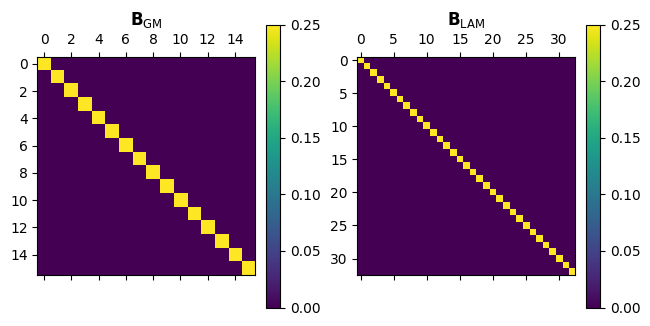

In [9]:
#sig_gm = np.diag(np.full(u0_gm.size,sigb))*np.sqrt(nx_gm)
#U_gm = idst(sig_gm,type=1,axis=0)
#B_gm = U_gm @ U_gm.transpose()
B_gm = np.diag(np.full(u0_gm.size,sigb*sigb))
#sig_lam = np.diag(np.full(u0_lam.size,sigb))*np.sqrt(nx_lam)
#U_lam = idst(sig_lam,type=1,axis=0)
#B_lam = U_lam @ U_lam.transpose()
B_lam = np.diag(np.full(u0_lam.size,sigb*sigb))

fig, axs = plt.subplots(ncols=2,constrained_layout=True)
p0=axs[0].matshow(B_gm)
fig.colorbar(p0,ax=axs[0],shrink=0.6)
axs[0].set_title(r'$\mathbf{B}_\mathrm{GM}$')
p1=axs[1].matshow(B_lam)
fig.colorbar(p1,ax=axs[1],shrink=0.6)
axs[1].set_title(r'$\mathbf{B}_\mathrm{LAM}$')
plt.show()

In [10]:
from analysis.var import Var
from analysis.var_nest import Var_nest
obsope_gm = Obs('linear',sigo,ix=ix_gm)
obsope_lam = Obs('linear',sigo,ix=ix_lam,icyclic=False)
var_gm = Var(obsope_gm, nx_gm, ix=ix_gm, bmat=B_gm)
var_lam = Var(obsope_lam, nx_lam, ix=ix_lam, bmat=B_lam, cyclic=False)
var_nest = Var_nest(obsope_lam, ix_gm, ix_lam, bmat=B_lam, sigv=sigb, cyclic=False, verbose=False)
_ = var_nest.calc_pf(u0_lam,B_lam,0)
ua_gm, _, _, _, _, _ = var_gm(u0_gm, B_gm, obs[0], ix_lam)
ua_lam, _, _, _, _, _ = var_lam(u0_lam, B_lam, obs[0], ix_lam)
ua_lam_nest, _, _, _, _, _ = var_nest(u0_lam, B_lam, obs[0], ix_lam, u0_gm)

2024-01-31 20:59:16,881 anl INFO operator=linear, obserr=0.5
2024-01-31 20:59:16,881 anl INFO nvars=1


2024-01-31 20:59:16,881 anl INFO operator=linear, obserr=0.5
2024-01-31 20:59:16,882 anl INFO nvars=1
2024-01-31 20:59:16,882 anl INFO model : model
2024-01-31 20:59:16,882 anl INFO pt=var op=linear sig=0.5
2024-01-31 20:59:16,883 anl INFO sigb=1.0 lb=-1.0 functype=gauss
2024-01-31 20:59:16,883 anl INFO bmat in=True
2024-01-31 20:59:16,883 anl INFO model : model
2024-01-31 20:59:16,884 anl INFO pt=var op=linear sig=0.5
2024-01-31 20:59:16,884 anl INFO sigb=1.0 lb=-1.0 functype=gauss
2024-01-31 20:59:16,884 anl INFO bmat in=True
2024-01-31 20:59:16,885 anl INFO Trunc1d: ntrunc=16 ftrunc=0.2424
2024-01-31 20:59:16,885 anl INFO model : model
2024-01-31 20:59:16,885 anl INFO pt=var_nest op=linear sig=0.5 lb=-1.0 functype=gauss
2024-01-31 20:59:16,885 anl INFO bmat in=True
2024-01-31 20:59:16,886 anl INFO sigv=0.5 lv=-1.0 nv=33
2024-01-31 20:59:16,886 anl INFO vmat in=False
2024-01-31 20:59:16,886 anl INFO crosscov=False
2024-01-31 20:59:16,887 anl INFO #positive eigenvalues in bmat=16
2024

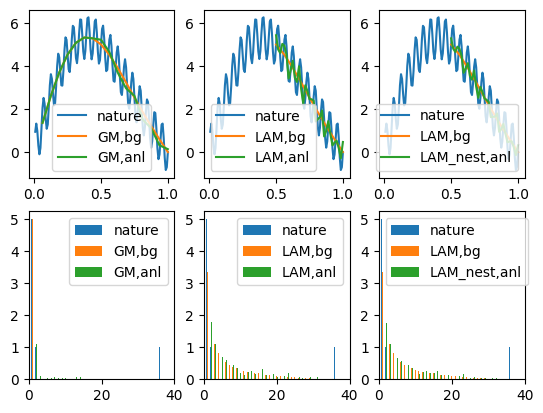

In [12]:
fig, axs = plt.subplots(nrows=2,ncols=3)
for ax in axs[0,]:
    ax.plot(x_t,u_t[0],label='nature')
axs[0,0].plot(x_gm, u0_gm, label='GM,bg')
axs[0,0].plot(x_gm, ua_gm, label='GM,anl')
axs[0,1].plot(x_lam, u0_lam, label='LAM,bg')
axs[0,1].plot(x_lam, ua_lam, label='LAM,anl')
axs[0,2].plot(x_lam, u0_lam, label='LAM,bg')
axs[0,2].plot(x_lam, ua_lam_nest, label='LAM_nest,anl')
y_t = dst(u_t[0][:-1],type=1)/nx_t
width=0.2
for ax in axs[1,]:
    ax.bar(np.arange(1,y_t.size+1)-width,np.abs(y_t),width=width,label='nature')
    ax.set_xlim(0,40)
yb_gm = dst(u0_gm[:-1],type=1)/nx_gm
ya_gm = dst(ua_gm[:-1],type=1)/nx_gm
axs[1,0].bar(np.arange(1,yb_gm.size+1),np.abs(yb_gm),width=width,label='GM,bg')
axs[1,0].bar(np.arange(1,ya_gm.size+1)+width,np.abs(ya_gm),width=width,label='GM,anl')
yb_lam = dst(u0_lam[:-1],type=1)/nx_lam
ya_lam = dst(ua_lam[:-1],type=1)/nx_lam
axs[1,1].bar(np.arange(1,yb_lam.size+1),np.abs(yb_lam),width=width,label='LAM,bg')
axs[1,1].bar(np.arange(1,ya_lam.size+1)+width,np.abs(ya_lam),width=width,label='LAM,anl')
ya_lam_nest = dst(ua_lam_nest[:-1],type=1)/nx_lam
axs[1,2].bar(np.arange(1,yb_lam.size+1),np.abs(yb_lam),width=width,label='LAM,bg')
axs[1,2].bar(np.arange(1,ya_lam_nest.size+1)+width,np.abs(ya_lam_nest),width=width,label='LAM_nest,anl')
for ax in axs.flatten():
    ax.legend()
plt.show()

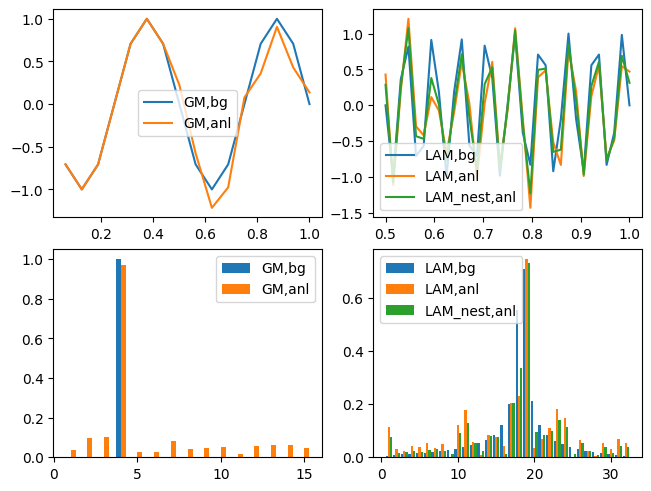

In [15]:
nature2model = interp1d(x_t,u_t[0])
errb_gm = u0_gm - nature2model(x_gm)
erra_gm = ua_gm - nature2model(x_gm)
errb_lam = u0_lam - nature2model(x_lam)
erra_lam = ua_lam - nature2model(x_lam)
erra_lam_nest = ua_lam_nest - nature2model(x_lam)

width=0.3
fig, axs = plt.subplots(nrows=2,ncols=2,constrained_layout=True)
axs[0,0].plot(x_gm, errb_gm, label='GM,bg')
axs[0,0].plot(x_gm, erra_gm, label='GM,anl')
axs[0,1].plot(x_lam, errb_lam, label='LAM,bg')
axs[0,1].plot(x_lam, erra_lam, label='LAM,anl')
axs[0,1].plot(x_lam, erra_lam_nest, label='LAM_nest,anl')
yb_gm = dst(errb_gm[:-1],type=1)/nx_gm
ya_gm = dst(erra_gm[:-1],type=1)/nx_gm
axs[1,0].bar(np.arange(1,yb_gm.size+1)-0.5*width,np.abs(yb_gm),width=width,label='GM,bg')
axs[1,0].bar(np.arange(1,ya_gm.size+1)+0.5*width,np.abs(ya_gm),width=width,label='GM,anl')
yb_lam = dst(errb_lam[:-1],type=1)/nx_lam
ya_lam = dst(erra_lam[:-1],type=1)/nx_lam
ya_lam_nest = dst(erra_lam_nest[:-1],type=1)/nx_lam
axs[1,1].bar(np.arange(1,yb_lam.size+1)-width,np.abs(yb_lam),width=width,label='LAM,bg')
axs[1,1].bar(np.arange(1,ya_lam.size+1),np.abs(ya_lam),width=width,label='LAM,anl')
axs[1,1].bar(np.arange(1,ya_lam_nest.size+1)+width,np.abs(ya_lam_nest),width=width,label='LAM_nest,anl')
for ax in axs.flatten():
    ax.legend()
plt.show()

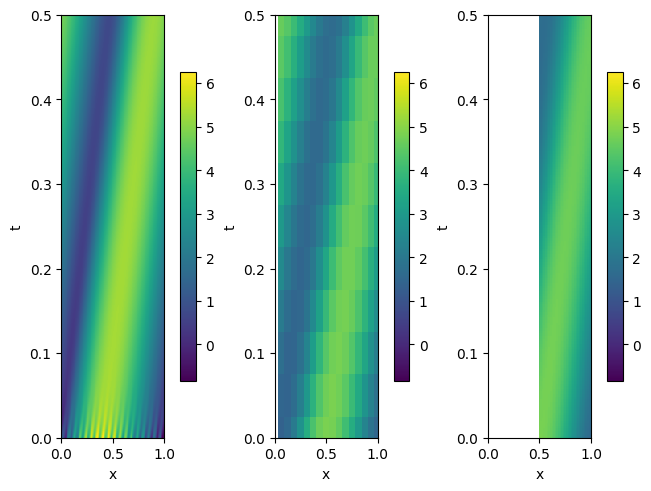

In [22]:
u_gm = []
u_lam = []
time_gm = []
time_lam = []
t = 0.0
u_gm.append(u0_gm)
u_lam.append(u0_lam)
time_gm.append(t)
time_lam.append(t)
i = 0
i0 = np.argmin(np.abs(x_gm - x_lam[0]))
i1 = np.argmin(np.abs(x_gm - x_lam[-1]))
davies_wgt = np.arange(nsponge)/nsponge
while (t<T):
    u1_gm = gm(u0_gm)
    for j in range(lamstep):
        uc_gm = (1.0 - j/lamstep)*u0_gm + j/lamstep*u1_gm
        gm2lamtmp = interp1d(x_gm,uc_gm)
        utmp = gm2lamtmp(x_lam)
        u0_lam[0] = utmp[0]
        u0_lam[-1] = utmp[-1]
        u1_lam = lam(u0_lam)
        u1_lam[0:nsponge] = davies_wgt*u1_lam[0:nsponge] + (1.0 - davies_wgt)*utmp[0:nsponge]
        u1_lam[-nsponge:] = davies_wgt[::-1]*u1_lam[-nsponge:] + (1.0 - davies_wgt[::-1])*utmp[-nsponge:]
        u_lam.append(u1_lam)
        u0_lam = u1_lam
        time_lam.append(t+dt_lam*(j+1))
    t+=dt_gm
    i+=1
    u_gm.append(u1_gm)
    u0_gm = u1_gm
    time_gm.append(t)
#    if i%128==0:
#        axs[0].plot(x_t,u0_t)
#        y_t = dst(u0_t[:-1],type=1)/nx_t
#        axs[1].bar(np.arange(1,y_t.size+1),np.abs(y_t))
#plt.show()

fig, axs = plt.subplots(ncols=3,constrained_layout=True)
vmin = min(np.min(u_t),np.min(u_gm),np.min(u_lam))
vmax = max(np.max(u_t),np.max(u_gm),np.max(u_lam))
p0=axs[0].pcolormesh(x_t,time,np.array(u_t),vmin=vmin,vmax=vmax)
p1=axs[1].pcolormesh(x_gm,time_gm,np.array(u_gm),vmin=vmin,vmax=vmax)
p2=axs[2].pcolormesh(x_lam,time_lam,np.array(u_lam),vmin=vmin,vmax=vmax)
for ax in axs:
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_ylim(0.0,T)
    ax.set_xlim(0.0,L)
fig.colorbar(p0,ax=axs[0])
fig.colorbar(p1,ax=axs[1])
fig.colorbar(p2,ax=axs[2])
plt.show()